In [2]:
#Making a WR-purposed MCMC fitting suite - to optimise fittings of TESS light curves of WR stars
import os, sys

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as ticker

import numpy as np

import astropy
from astropy.io import fits
from astropy.io import ascii
import astropy.units as u
# from astropy.utils.data import get_pkg_data_filename   #time-series extraction tool
from astropy.timeseries import TimeSeries
from astropy.timeseries import LombScargle

import math 

import lightkurve as lk    #good time-series library

import pandas as pd

from scipy.optimize import curve_fit
from scipy.optimize import minimize

import emcee
import corner

#from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum

In [12]:
#Searching WR139 lightcurves
wr_search = lk.search_lightcurve("WR139", mission="TESS", exptime=120, radius=60)
wr139_lc1 = wr_search[0].download()
#wr139_lc1 = wr139_lc1.remove_nans().remove_outliers().fill_gaps()
wr139_lc1

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1683.356807547368,1.9542975e+05,5.0235626e+01,2.9053912e-03,328247,748.62434,755.79823,1.8319711e+05,4.6981342e+01,6.2838481e+03,8.3916464e+00,1.9542975e+05,5.0235626e+01,0,nan,nan,nan,nan,748.62434,2.2740928e-04,755.79823,2.1515937e-04,1.9847333e-02,3.2403585e-02
1683.358196466864,1.9544638e+05,5.0231850e+01,2.9054224e-03,328248,748.62329,755.80044,1.8316930e+05,4.6977814e+01,6.2894365e+03,8.3891687e+00,1.9544638e+05,5.0231850e+01,0,nan,nan,nan,nan,748.62329,2.2755761e-04,755.80044,2.1516807e-04,1.8971941e-02,3.5028078e-02
1683.3595853865934,1.9564822e+05,5.0251972e+01,2.9054538e-03,328249,748.62809,755.80004,1.8332877e+05,4.6996628e+01,6.2907119e+03,8.3861198e+00,1.9564822e+05,5.0251972e+01,0,nan,nan,nan,nan,748.62809,2.2728613e-04,755.80004,2.1524064e-04,2.3694687e-02,3.4768403e-02
1683.3609743063219,1.9562748e+05,5.0255386e+01,2.9054852e-03,328250,748.62792,755.80357,1.8328403e+05,4.6999825e+01,6.2836387e+03,8.4081402e+00,1.9562748e+05,5.0255386e+01,0,nan,nan,nan,nan,748.62792,2.2738130e-04,755.80357,2.1509195e-04,2.3609096e-02,3.9015554e-02
1683.3623632258173,1.9591744e+05,5.0275669e+01,2.9055164e-03,328251,748.62854,755.79603,1.8351523e+05,4.7018791e+01,6.2727700e+03,8.3850336e+00,1.9591744e+05,5.0275669e+01,0,nan,nan,nan,nan,748.62854,2.2713174e-04,755.79603,2.1511738e-04,2.4668077e-02,2.9974846e-02
1683.3637521455464,1.9595869e+05,5.0277157e+01,2.9055479e-03,328252,748.62757,755.79849,1.8355939e+05,4.7020184e+01,6.2787788e+03,8.3747387e+00,1.9595869e+05,5.0277157e+01,0,nan,nan,nan,nan,748.62757,2.2714444e-04,755.79849,2.1496970e-04,2.3219401e-02,3.2648951e-02
1683.3651410650425,1.9592022e+05,5.0254894e+01,2.9055791e-03,328253,748.62925,755.80403,1.8337270e+05,4.6999363e+01,6.2828252e+03,8.3848152e+00,1.9592022e+05,5.0254894e+01,0,nan,nan,nan,nan,748.62925,2.2728783e-04,755.80403,2.1537289e-04,2.4942067e-02,3.8866829e-02
1683.366529984772,1.9618520e+05,5.0302513e+01,2.9056105e-03,328254,748.62857,755.80155,1.8373464e+05,4.7043900e+01,6.2768584e+03,8.3860035e+00,1.9618520e+05,5.0302513e+01,0,nan,nan,nan,nan,748.62857,2.2694022e-04,755.80155,2.1475699e-04,2.4184732e-02,3.6717471e-02


Text(0.5, 1.0, 'PDCSAP Light Curve of WR139 - ts1')

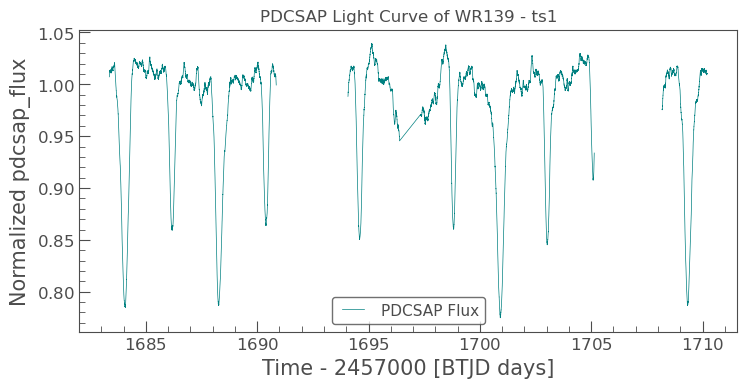

In [4]:
ax = wr139_lc1.plot(column='pdcsap_flux', label='PDCSAP Flux', color='teal', normalize=True)    #PDCSAP flux
ax.set_title('PDCSAP Light Curve of WR139 - ts1')

In [14]:
#Lomb-Scargle Periodogram - normalised to parts per million
freq = np.linspace(0.1, 100, 100)
pg_wr139_lc1 = wr139_lc1.normalize(unit='ppm').to_periodogram()   #plot with less points
#pg_wr139_lc1 = pg_wr139_lc1.bin(binsize=20, method='mean')

Text(0.5, 1.0, 'Lomb-Scargle periodogram - normal')

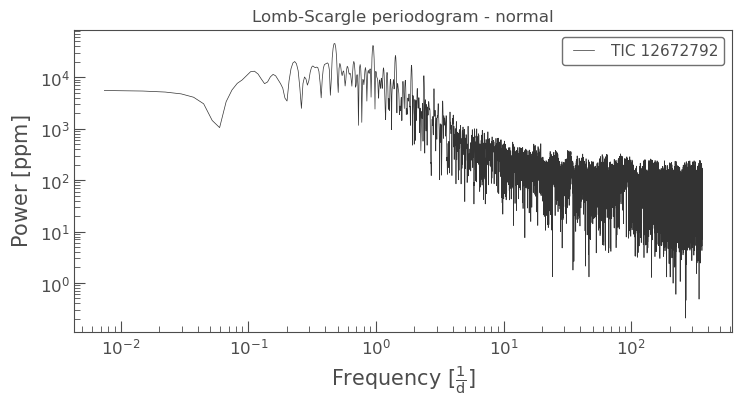

In [6]:
#Inspecting the periodogram (bin)
ax = pg_wr139_lc1.plot(view='frequency', scale='log')
#ax.set_xlim(0,20)
ax.set_title('Lomb-Scargle periodogram - normal')
#plt.savefig('LS_lc1_log_noline')

In [15]:
pg_wr139_lc1.period   #period at max power
pg_wr139_lc1.power[0].value   #first data-point power
print (len(pg_wr139_lc1.power.value))
# t = wr139_lc1.time
# y = wr139_lc1.flux
# dy = wr139_lc1.flux_err
# frequency, power = LombScargle(t, y).autopower()
# plt.plot(frequency, power)

48329


Text(0.5, 1.0, 'Lomb-Scargle periodogram - normal')

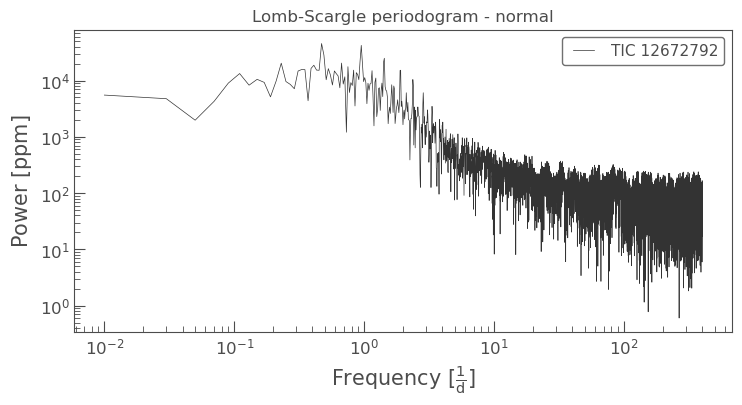

In [8]:
#Re-draw LS
short_freq = np.linspace(0.01, 400, 20000)
pg_wr139_lc1 = wr139_lc1.normalize(unit='ppm').to_periodogram(frequency=short_freq)
#pg_wr139_lc1 = pg_wr139_lc1.bin(binsize=15, method='mean')

x = getattr(pg_wr139_lc1, 'frequency')   #frequency array
y = getattr(pg_wr139_lc1, 'power')       #power (ppm) array

freq = [float(i/(1*x.unit)) for i in x]        #converting to scalars
amp_pow = [float(j/(1*y.unit)) for j in y]

ax = pg_wr139_lc1.plot(view='frequency', scale='log')
ax.set_title('Lomb-Scargle periodogram - normal')

#print ((freq))

In [600]:
#Defining likelihood, flat prior and combined to probability
#a1 = v_c, a2 = gamma, a3 = C_w // x = \nu

def model(theta, freq=freq):
    a0, a1, a2, a3 = theta
    return (a0/(1+(freq/a1)**a2)) + a3

def log_likelihood(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2) 

#define flat prior
def log_prior(theta):
    a0, a1, a2, a3 = theta
    if 10**3 < a0 < 10**5 and 10**-1 < a1 < 10**1 and 0 < a2 < 20 and 10**1 < a3 < 10**3:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr) 

In [601]:
# np.random.seed(42)
# nll = lambda *args: -log_likelihood(*args)
# initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
# soln = minimize(nll, initial, args=(x, y, yerr))
# m_ml, b_ml, log_f_ml = soln.x

# print("Maximum likelihood estimates:")
# print("m = {0:.3f}".format(m_ml))
# print("b = {0:.3f}".format(b_ml))
# print("f = {0:.3f}".format(np.exp(log_f_ml)))

In [602]:
#Define 'true' values of a0, a1, a2, a3 and assuming an error of amplitude power
a0_true = 10**4
a1_true = 2
a2_true = 2
a3_true = 80
amp_err = 0.05*np.mean(amp_pow)

#Setting up for ensemble sampler
data = [freq, amp_pow, amp_err]
nwalkers = 120
niter = 2400
initial = np.array([a0_true, a1_true, a2_true, a3_true])
ndim = len(initial)
p0 = [np.array(initial) + 1e-6 * np.random.randn(ndim) for i in range(nwalkers)]

In [603]:
def main(p0,nwalkers,niter,ndim,log_probability,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 120)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,log_probability,data)

Running burn-in...


  0%|                                                       | 3/2400 [00:00<01:40, 23.78it/s]

Running production...


100%|████████████████████████████████████████████████████| 2400/2400 [01:42<00:00, 23.33it/s]


In [604]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([1.18241480e+04, 1.73558277e+00, 1.44259823e+01, 1.10465628e+02])

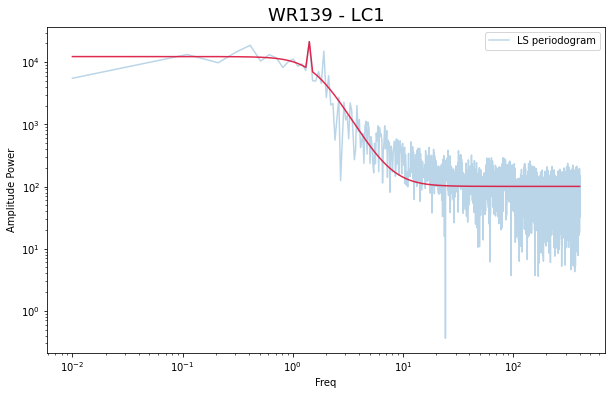

In [24]:
def plotter(sampler,freq,amp_pow, max_like):
    plt.ion()
    plt.subplots(figsize=(10, 6))
    plt.yscale('log')
    plt.xscale('log')
    plt.plot(freq,amp_pow,label='LS periodogram', alpha=0.3)
    samples = sampler.flatchain
    
    #choose max-likelihood model
    if max_like:
        theta = samples[np.argmax(sampler.flatlnprobability)]
        plt.plot(freq, model(theta, freq), color='crimson', alpha=0.9)
    else:
        for theta in samples[np.random.randint(len(samples), size=100)]:
            plt.plot(freq, model(theta, freq), color="r", alpha=0.1)
        
    #plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.title('WR139 - LC1', fontsize=18)
    plt.xlabel('Freq')
    plt.ylabel('Amplitude Power')
    plt.legend()
    plt.show()

plotter(sampler, freq, amp_pow, True)

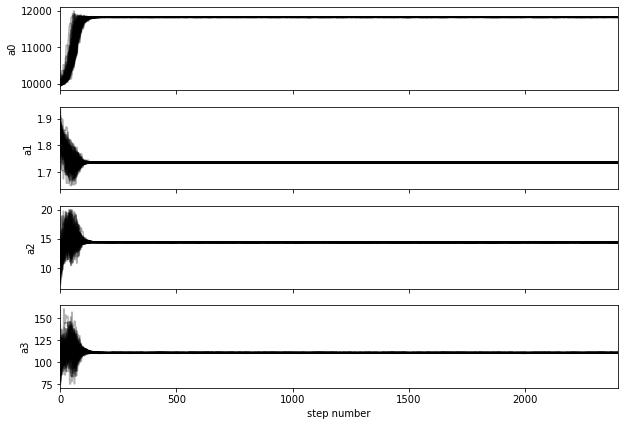

In [606]:
#Inspecting what the sampler has done
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a0", "a1", "a2", "a3"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [607]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 48;
tau: [71.88002478 31.93462156 20.99286995 29.50639762]

In [608]:
flat_samples = sampler.get_chain(discard=160, thin=35, flat=True)
print(flat_samples.shape)

(7680, 4)


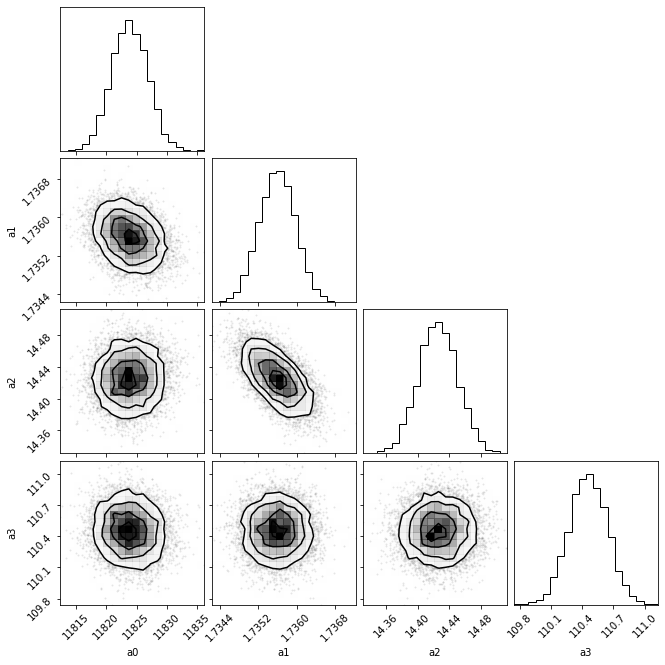

In [609]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[a0_true, a1_true, a2_true, a3_true]
);

In [230]:
# #detecting nan-values from light curve data
# def nan_hunter(lc):
#     pos_tab = []
#     pdcsap_tab = lc.pdcsap_flux.value
#     for i in range (len(pdcsap_tab)):
#         if math.isnan(pdcsap_tab[i]):
#             pos_tab.append(i)
#     return pos_tab

# #print (nan_hunter(wr139_lc1))

In [231]:
#interpolating nan-values by patching them with median values from nearest neighbours - using this handy nan_helper function
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """
    return np.isnan(y), lambda z: z.nonzero()[0]

# #Taking care of all nan-values of all columns (if there is any)
# lc_heads = wr139_lc1.colnames
# print (lc_heads)
# #print (np.isnan(hd_lc1.columns[13].value).all())
# for i in range (len(lc_heads)):
#     #print (i)
#     col_dat = wr139_lc1.columns[i].value
#     #print (col_dat)
#     if np.isnan(col_dat).all() != True:
#         nans, x= nan_helper(col_dat)
#         col_dat[nans]= np.interp(x(nans), x(~nans), col_dat[~nans])

#Test to see if there are nans left
#print (nan_hunter(wr139_lc1))

In [232]:
# #Experiment with re-binning power spectrum with Stingray
# stray_lc1 = Lightcurve.from_lightkurve(wr139_lc1, skip_checks=False)
# #bin_stray_lc1 = Lightcurve.make_lightcurve(stray_lc1, dt=(2/(60*24)), tstart=1468.273575668771, tseg=1490.048908790299) 
# stray_lc1_ps = Powerspectrum(stray_lc1)
# stray_rb_ps1 = stray_lc1_ps.rebin_log(f=0.02)
# print (stray_rb_ps1.df)
# print(type(stray_rb_ps1))

In [233]:
# fig, ax1 = plt.subplots(1,1,figsize=(9,6))
# ax1.plot(stray_rb_ps1.freq, stray_rb_ps1.power, lw=2, color='blue')
# ax1.set_xlabel("Frequency")
# ax1.set_ylabel("Power")
# ax1.set_yscale('log')
# ax1.set_xscale('log')
# ax1.tick_params(axis='x', labelsize=16)
# ax1.tick_params(axis='y', labelsize=16)
# ax1.tick_params(which='major', width=1.5, length=7)
# ax1.tick_params(which='minor', width=1.5, length=4)

# plt.show()
# plt.grid()

# print(stray_rb_ps1.freq)
# print(stray_rb_ps1.power)

# #p0=[15, 5e-6, 3, 2e-5]

In [234]:
# #Fitting with MCMC
# #Redefine flat priors to match with new re-binned power spectrum
# def rb_model(theta, freq=stray_rb_ps1.freq):
#     a0, a1, a2, a3 = theta
#     return (a0/(1+(freq/a1)**a2)) + a3

# def rb_log_likelihood(theta, x, y, yerr):
#     return -0.5 * np.sum(((y - rb_model(theta, x))/yerr) ** 2) 

# def rb_log_prior(theta):
#     a0, a1, a2, a3 = theta
#     if 10**0 < a0 < 10**3 and 10**-6 < a1 < 10**-4 and 0 < a2 < 10 and 10**-6 < a3 < 10**-4:
#         return 0.0
#     return -np.inf

# def rb_log_probability(theta, x, y, yerr):
#     lp = rb_log_prior(theta)
#     if not np.isfinite(lp):
#         return -np.inf
#     return lp + rb_log_likelihood(theta, x, y, yerr)

# #Define 'true' values of a0, a1, a2, a3 and assuming an error of amplitude power
# a0_rb = 100
# a1_rb = 5e-6
# a2_rb = 4
# a3_rb = 1e-5
# amp_err_rb = 0.05*np.mean(stray_rb_ps1.power)

# rb_data = [stray_rb_ps1.freq, stray_rb_ps1.power, amp_err_rb]
# nwalkers = 240
# niter = 3000
# initial = np.array([a0_rb, a1_rb, a2_rb, a3_rb])
# ndim = len(initial)
# p0 = [np.array(initial) + 1e-6 * np.random.randn(ndim) for i in range(nwalkers)]

# sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,rb_log_probability,rb_data)

In [235]:
# samples = sampler.flatchain
# samples[np.argmax(sampler.flatlnprobability)]

In [236]:
# plotter(sampler, stray_rb_ps1.freq, stray_rb_ps1.power)

In [237]:
# tau = sampler.get_autocorr_time()
# print(tau)

In [238]:
# #discard a few times the no. of steps (as burn-in) from autocorr time & thin by half-ish of it
# flat_samples = sampler.get_chain(discard=250, thin=60, flat=True)
# print(flat_samples.shape)

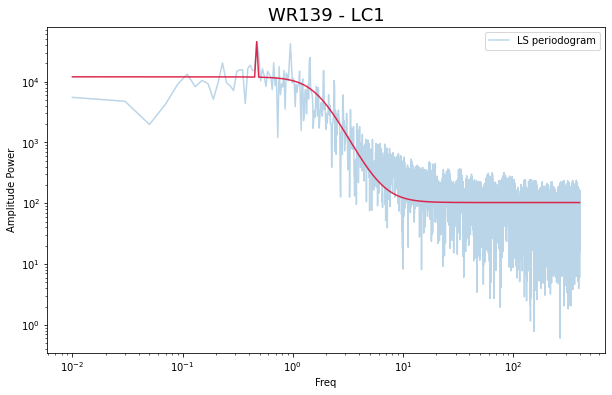

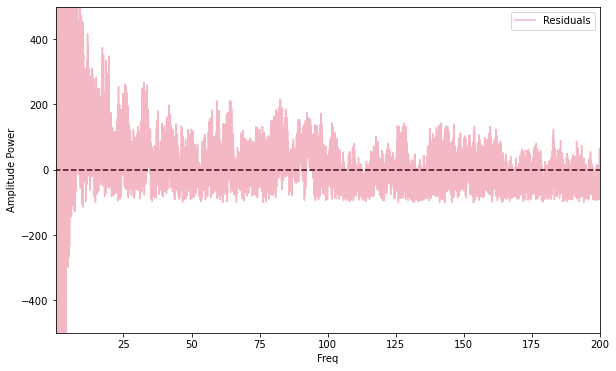

In [36]:
# fig = corner.corner(
#     flat_samples, labels=labels, truths=[a0_rb, a1_rb, a2_rb, a3_rb]
# );

def residual_max(sampler, x, y):
    samples = sampler.flatchain
    #choose max-likelihood model
    theta = samples[np.argmax(sampler.flatlnprobability)]   
    res = y - model(theta, x)
#     res_err = np.median(res)
#     print (np.median(res))
    
    plt.subplots(figsize=(9.75, 6))
    plt.plot(x, res, color='crimson', alpha=0.3, label='Residuals')
    #plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlim(0.1,200)
    plt.ylim(-500,500)
    plt.hlines(0,0,400, linestyles='dashed', alpha=1, color='black')
    plt.xlabel('Freq')
    plt.ylabel('Amplitude Power')
    plt.legend()
    plt.show()
    
plotter(sampler, freq, amp_pow, True)
residual_max(sampler, freq, amp_pow)

Testing with fitting the amplitude spectrum function with an additional Lorentzian term to identify peak position. We modify our formula as such: 

$$\alpha(\nu) = \frac{\alpha_0}{1+(\frac{\nu}{\nu_c})^\gamma} + C_w + \frac{1}{\pi\lambda} \bigg[\frac{\lambda^2}{(\nu-\nu_0)^2 + \lambda^2}\bigg]$$

where $\nu_0$ specifies the location of the peak and $\lambda$ is the scale parameter dictating the half-width-half-maximum (HWHM) and the rest of the parameters are the usuals as specified by Bowman et al. (2019)

In [29]:
#Testing cell for new model
#Defining likelihood, flat prior and combined to probability
#a1 = v_c, a2 = gamma, a3 = C_w, a4 = \nu_0, a5 = lambda // x = \nu

def model(theta, freq=freq):
    a0, a1, a2, a3, a4, a5 = theta
    return (a0/(1+(freq/a1)**a2)) + a3 + (1/(np.pi*a5))*((a5**2)/(((freq-a4)**2) + a5**2))

def log_likelihood(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2) 

#define flat prior
def log_prior(theta):
    a0, a1, a2, a3, a4, a5 = theta
    if 10**3 < a0 < 10**5 and 10**-1 < a1 < 10**1 and 0 < a2 < 20 and 10**1 < a3 < 10**3 and 10**-1 < a4 < 10**1 and 0 < a5 < 10**1:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr) 

In [30]:
#Define 'true' values of a0, a1, a2, a3 and assuming an error of amplitude power
a0_true = 10**4
a1_true = 2
a2_true = 2
a3_true = 80
a4_true = 2
a5_true = 0.5
amp_err = 0.05*np.mean(amp_pow)

#Setting up for ensemble sampler
data = [freq, amp_pow, amp_err]
nwalkers = 120
niter = 2400
initial = np.array([a0_true, a1_true, a2_true, a3_true, a4_true, a5_true])
ndim = len(initial)
p0 = [np.array(initial) + 1e-6 * np.random.randn(ndim) for i in range(nwalkers)]

In [31]:
def main(p0,nwalkers,niter,ndim,log_probability,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 120)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,log_probability,data)

Running burn-in...
Running production...


100%|██████████████████████████████████████████████████████████████████████████████| 2400/2400 [14:40<00:00,  2.73it/s]


In [32]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([1.18993584e+04, 1.67125087e+00, 3.56638275e+00, 1.02620778e+02,
       4.70011980e-01, 9.45847561e-06])

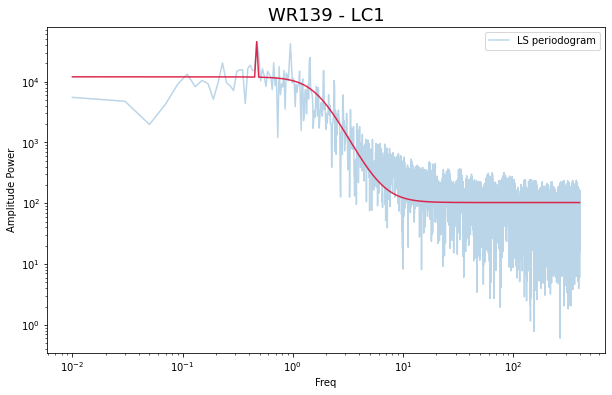

In [34]:
plotter(sampler, freq, amp_pow, True)